# Cascaded integrator–comb (CIC) filters

In [1]:
from math import log
import numpy as np
import matplotlib.pyplot as plt
np.seterr(divide='ignore', invalid='ignore');
fftResolution = 1024

## Introduction
CIC filters are computationally efficient implementations of narrowband lowpass filters. They are particularly suited for use as an anti-aliasing filter when decimating or an anti-image filter when interpolating. CIC filters are well suited for implementation in FPGAs and ASICs as they only require addition and subtraction operations and not multiplication [1]. 

CIC filters have a non-flat passband and as such are typically used in combination with a FIR filter which compensates for the passband droop [2]. In both interpolation and decimation, the FIR filter operates at the lower sample rate allowing for efficient FIR implementations that can take advantage of time-sharing.

* [1] Lyons, R. *Understanting Digital Signal Processing. Third Edition*, pp. 550-565
* [2] Altera Corporation, *Understanding CIC Compensation Filters. Application Note 455*

## How do CIC filters work?
The best way to understand how a CIC filter works is to start with a simple moving average filter and gradually work towards the efficient implementation of a CIC filter. Additionally, while CIC filters are almost always used as part of a resampling operation it is best to initially analyse them purely as a single rate filter.

### Moving average filter
A D point moving average filter sums the current sample with the previous D-1 samples and multiplies the result by 1/D.

![Moving Average Filter](images/moving_average_filter.svg "Moving Average Filter")

The magnitude of the frequency response of a moving average filter is given by:
$$\left | H(\omega ) \right | = \frac{1}{D}\left | \frac{\sin \left ( \frac{\omega D}{2} \right )}{\sin \left ( \frac{\omega }{2} \right )} \right |$$

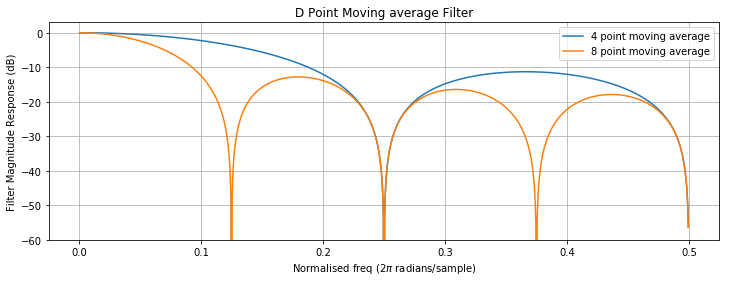

In [2]:
plt.figure(figsize=(12,4))
def movingAverageFreqResponse(D):
    Hfunc = lambda w : np.abs( (np.sin((w*D)/2.0)) / (np.sin((w)/2.0)) ) * (1.0/D)    
    w = np.arange(fftResolution) * np.pi/fftResolution
    H = np.array(list(map(Hfunc, w)))
    plt.plot(w/(2*np.pi),(20*np.log10((H))), label="{} point moving average".format(D))
    
movingAverageFreqResponse(4)
movingAverageFreqResponse(8)    
axes = plt.gca()
axes.set_ylim([-60,3])
plt.grid()
plt.legend()
plt.title('D Point Moving average Filter')
plt.xlabel('Normalised freq (2$\pi$ radians/sample)')
plt.ylabel('Filter Magnitude Response (dB)')
plt.show()

It can be seen that a moving average filter is a lowpass filter with a sinc like frequency response. The location of the first null is set by the number of points the moving average is calculated over. For a 4-point moving average filter there is a null at fs/4 and 2\*fs/4 where fs is the sample rate. In general, there will be nulls at intervals of fs/D.
### Running sum filter
It can be seen that removing the multiplication by 1/D will cause there to be a gain of D, but otherwise the frequency response is unchanged. A moving average filter without the multiplication by 1/D is known as a running sum filter.

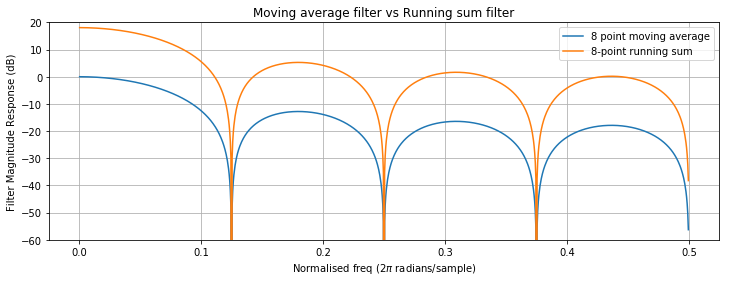

In [3]:
plt.figure(figsize=(12,4))
def runningSumFreqResponse(D):
    Hfunc = lambda w : np.abs( (np.sin((w*D)/2.0)) / (np.sin((w)/2.0)) )    
    w = np.arange(fftResolution) * np.pi/fftResolution
    H = np.array(list(map(Hfunc, w)))
    plt.plot(w/(2*np.pi),(20*np.log10((H))), label="{}-point running sum".format(D))
    
movingAverageFreqResponse(8)
runningSumFreqResponse(8)    
axes = plt.gca()
axes.set_ylim([-60,20])
plt.grid()
plt.legend()
plt.title('Moving average filter vs Running sum filter')
plt.xlabel('Normalised freq (2$\pi$ radians/sample)')
plt.ylabel('Filter Magnitude Response (dB)')
plt.show()

Both the moving average filter and the running sum filter require D-1 summations to compute each output sample. A recursive running sum filter performs the same operation but only needs to compute one addition and one subtraction per output sample.

![Recursive Running Sum Filter](images/recursive_running_sum.svg "Recursive Running Sum Filter")

It is relatively intuitive that this produces the same response as the regular running sum filter. The integrator at the output sums every sample that enters it, however left part of the filter (the comb) ensures that for every sample that is added to the integrator, D inputs later it will be subtracted from integrator. The integrator can be thought of as keeping track of the sum of what would have been inside the running sum window.

The filter is stable providing the additions and subtractions are performed exactly. It is for this reason that a recursive running sum filter, and as we will see later a CIC filter, will only work with fixed point maths; the errors introduced by floating point calculations would eventually accumulate in the integrator.

### CIC filter
As it turns out a recursive running sum filter is actually CIC filter of order 1. 

![CIC filter](images/cic_filter_order1.svg "CIC Filter")

#### Comb then integrator or integrator then comb?
Both the integrator and comb are linear time-invariant operations. This means we can swap the integrator and comb sections without changing the output. It is worth pointing out that with the integrator first the output of the integrator could be massive, but providing the system is implemented using 2-complement maths, and the bit widths are sufficient to hold the final output sample the integrator will simply wrap round without causing any issues. The bit widths required to implement a CIC filter will be covered later.




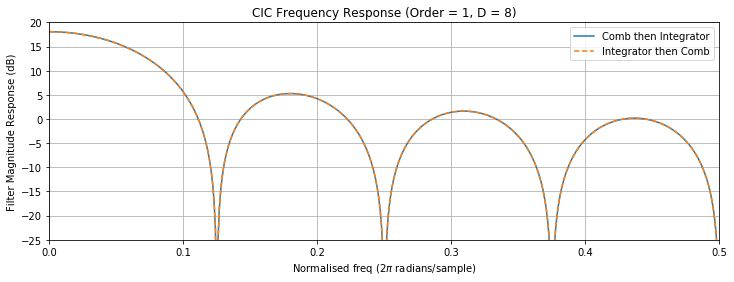

In [4]:
# NB The comb and integrator are implemented for clarity and not efficiency!
def comb(inData, D):
    outData = []
    delay = [0] * D
    for sample in inData:
        outData.append(sample - delay[-1])
        delay = [sample] + delay
        delay.pop()
    return outData

def integrator(inData):
    delay = 0
    outData = []
    for sample in inData:
        y = delay + sample    
        outData.append(y)
        delay = y
    return outData

impulse = [1]+[0]*(fftResolution)
impulseResponse = integrator(comb(impulse, 8)) # Apply the comb with delay 8, then the integrator.
impulseResponse2 = comb(integrator(impulse),8) # Apply the integrator, then the comb with delay 8.
# Plot result
# Only plot the positive frequencies (-ive freqs are just an image of +ive)
xaxis = np.arange(fftResolution/2) * 0.5/(fftResolution/2)
plt.figure(figsize=(12,4))
plt.plot(xaxis,(20*np.log10(np.abs(np.fft.fft(impulseResponse))))[0:int(fftResolution/2)], label="Comb then Integrator")
plt.plot(xaxis,(20*np.log10(np.abs(np.fft.fft(impulseResponse2))))[0:int(fftResolution/2)],'--', label="Integrator then Comb")
axes = plt.gca() 
axes.set_xlim([0,0.5])
axes.set_ylim([-25,20])
plt.grid()
plt.legend()
plt.title('CIC Frequency Response (Order = 1, D = 8)')
plt.xlabel('Normalised freq (2$\pi$ radians/sample)')
plt.ylabel('Filter Magnitude Response (dB)')
plt.show()

For optimisation reasons, which we will soon cover, when used for decimation the integration operation is performed first, followed by the comb. For interpolation the opposite is true with the comb operation coming first, followed by the integration.

![CIC filter](images/cic_filter.svg "CIC Filter")

#### Setting the delay (D) value
Typically if we wish to interpolate or decimate by a factor of R then D is set to an integer multiple of R, normally 1 or 2. By  making sure that D is an integer multiple of R some optimisations can be made in the implementation of the CIC filter. Typically it is noted as D = M\*R where M is called the differential delay. 

In the graph below the filter response of a CIC filter is shown for when M is 1 and 2. 


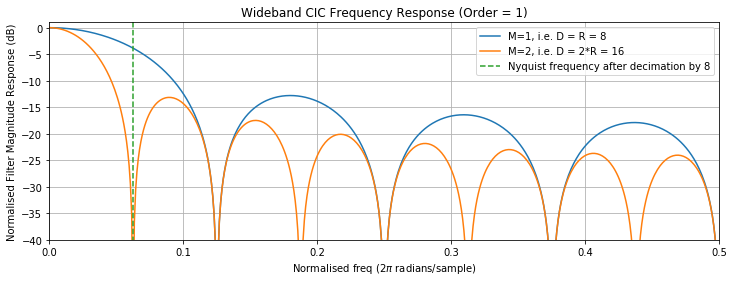

In [5]:
plt.figure(figsize=(12,4))
impulse = [1]+[0]*(fftResolution)
impulseResponse3 = np.array(comb(integrator(impulse), 8))/8 # Divided by 8 to normalise gain
impulseResponse4 = np.array(comb(integrator(impulse),16))/16 # Divided by 16 to normalise gain
# Plot result
xaxis = np.arange(fftResolution/2) * 0.5/(fftResolution/2)
plt.plot(xaxis,(20*np.log10(np.abs(np.fft.fft(impulseResponse3))))[0:int(fftResolution/2)], label="M=1, i.e. D = R = 8")
plt.plot(xaxis,(20*np.log10(np.abs(np.fft.fft(impulseResponse4))))[0:int(fftResolution/2)], label="M=2, i.e. D = 2*R = 16")
plt.plot([0.0625,0.0625],[-45,1], '--', label="Nyquist frequency after decimation by 8")
axes = plt.gca() 
axes.set_xlim([0,0.5])
axes.set_ylim([-40,1])
plt.grid()
plt.legend()
plt.title('Wideband CIC Frequency Response (Order = 1)')
plt.xlabel('Normalised freq (2$\pi$ radians/sample)')
plt.ylabel('Normalised Filter Magnitude Response (dB)')
plt.show()

The vertical dotted line in the above graph shows the Nyquist frequency after a decimation by a factor of 8. After decimation everything to the right of the line will be aliased into the passband of the filter. The aliases will be attenuated according to the frequency response shown in the graph. If this filter was used for interpolation then everything to the left of the green line would appear imaged throughout the new bandwidth. The images would be attenuated according to the frequency response shown in the graph.

#### Increasing CIC Attenuation
It is often important to achieve as much attenuation as possible. The frequency response of an order-1 CIC filter would not be sufficient in many applications. The attenuation can be increased by increasing the CIC order. 

With a CIC filter the order is increased by simply cascading additional integrator and comb sections. The number of integrators and combs must be equal. An order-1 CIC has one integrator and one comb, an order-2 has two integrators and two combs, etc.

![CIC filter](images/cic_filter_order2.svg "CIC Filter")

The magnitude of the wideband CIC filter frequency response of order N is given by:
$$\left | H(\omega ) \right | = \left | \frac{\sin \left ( \frac{\omega D}{2} \right )}{\sin \left ( \frac{\omega }{2} \right )} \right |^{N}$$

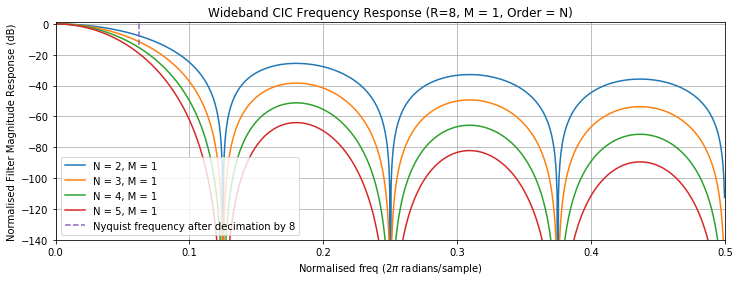

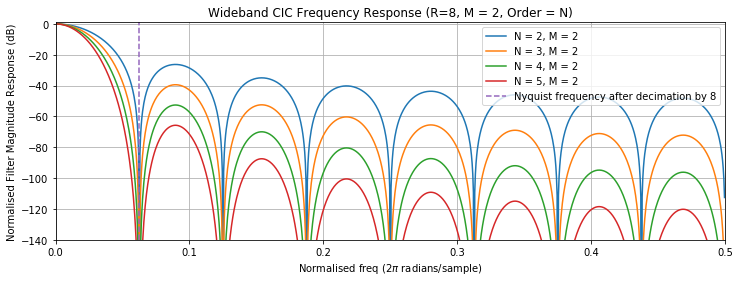

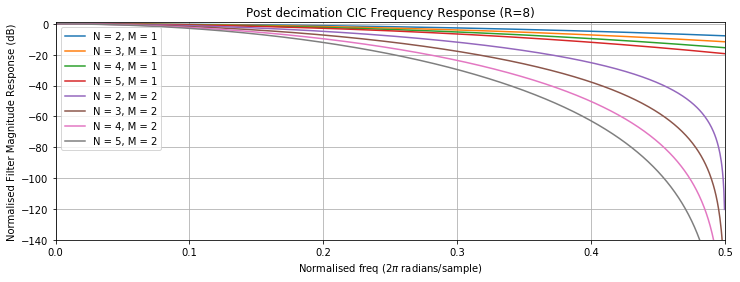

In [6]:
def plotCICResponse(R,M,N, widebandResponse=1):
    D = R*M
    if widebandResponse:
        Hfunc = lambda w : np.abs( (np.sin((w*D)/2)) / (np.sin(w/2.)) )**N
    else:
        Hfunc = lambda w : np.abs( (np.sin((w*M)/2.)) / (np.sin(w/(2.*R))) )**N
    w = np.arange(fftResolution) * np.pi/fftResolution
    gain = (M*R)**N
    magResponse = np.array(list(map(Hfunc, w)))
    plt.plot(w/(2*np.pi), 20.0*np.log10(magResponse/gain), label="N = {}, M = {}".format(N,M))

def plotConfig(title):
    axes = plt.gca(); axes.set_xlim([0,0.5]); axes.set_ylim([-140,1])
    plt.grid(); plt.legend()
    plt.title(title)
    plt.xlabel('Normalised freq (2$\pi$ radians/sample)')
    plt.ylabel('Normalised Filter Magnitude Response (dB)')
    plt.show()
    
# Plot 1
plt.figure(figsize=(12,4))
plotCICResponse(R=8,M=1,N=2) 
plotCICResponse(R=8,M=1,N=3) 
plotCICResponse(R=8,M=1,N=4)
plotCICResponse(R=8,M=1,N=5)
plt.plot([0.0625,0.0625],[-14,1], '--', label="Nyquist frequency after decimation by 8")
plotConfig("Wideband CIC Frequency Response (R=8, M = 1, Order = N)")
# Plot 2
plt.figure(figsize=(12,4))
plotCICResponse(R=8,M=2,N=2) 
plotCICResponse(R=8,M=2,N=3) 
plotCICResponse(R=8,M=2,N=4)
plotCICResponse(R=8,M=2,N=5)
plt.plot([0.0625,0.0625],[-140,1], '--', label="Nyquist frequency after decimation by 8")
axes = plt.gca(); axes.set_xlim([0,0.5]); axes.set_ylim([-140,1])
plotConfig("Wideband CIC Frequency Response (R=8, M = 2, Order = N)")
# Plot 3
plt.figure(figsize=(12,4))
plotCICResponse(R=8,M=1,N=2, widebandResponse=0) 
plotCICResponse(R=8,M=1,N=3, widebandResponse=0) 
plotCICResponse(R=8,M=1,N=4, widebandResponse=0)
plotCICResponse(R=8,M=1,N=5, widebandResponse=0)
plotCICResponse(R=8,M=2,N=2, widebandResponse=0) 
plotCICResponse(R=8,M=2,N=3, widebandResponse=0) 
plotCICResponse(R=8,M=2,N=4, widebandResponse=0)
plotCICResponse(R=8,M=2,N=5, widebandResponse=0)
plotConfig("Post decimation CIC Frequency Response (R=8)")

## Gain of a CIC
CIC filters have an inherent gain as a result of summing the D delayed samples. It is common to cancel out the gain after the CIC filter by multiplying by $\frac{1}{gain}$. Additionally, it is often possible to design the filter such that the gain is a power of two and can be cancelled using a binary right shift operation.

*NB. This gain has been cancelled out in most of the plots above in order to make the plots easier to compare.*
### Decimator
For a decimator the gain is given by:

$Gain = D^{N} = \left ( RM \right )^{N}$ where R = decimation factor, M = Differential delay, and N = CIC order

When implementing a CIC decimator the register size must be set according to the formula below or overflows errors will occur.

$registerWidth = inputDataWidth + \left \lceil N\log_{2}\left ( RM \right ) \right \rceil$

i.e. for a 16bit input word decimated by 8 with a CIC of order 3 and a differential delay of 1 the size of the registers used to store the integrator and comb data must be at least $16 + \left \lceil 3\log_{2}\left ( 8*1 \right ) \right \rceil = 25 bits$
### Interpolator
When interpolating, as a result of the zero padding, there is a gain of $\frac{1}{R}$ in addition to the gain of the CIC. As a result the gain of a CIC interpolator is given by:

$Gain = \frac{\left ( RM \right )^{N} }{R}$ where R = interpolation factor, M = Differential delay, and N = CIC order

When implementing a CIC interpolator the register size must be set according to the formula below or overflows errors will occur.

$registerWidth = inputDataWidth + \left \lceil \frac{N\log_{2}\left ( RM \right )}{R} \right \rceil$

## Implementing the CIC
Until now we have kept the resampler separate from the CIC filter in order to make analysis easier. The key advantage of CICs are their comutational efficiency when resampling. In order to achieve this computational efficiency, it is possible to slide the resampler through the comb section of the CIC. 

In the case of the decimator the down-sampler is moved back through the comb. A comb with a delay of D followed by a rate-R down-sampler will produce exactly the same results as a rate-R down-sampler followed by a comb with a delay of D/R. Since we set D to always be an integer multiple (M) of R, the delay can be set to: $\frac{D}{R} = \frac{RM}{R} = M$.

In the case of the interpolator the up-sampler is moved forwards through the comb. An rate-R up-sampler followed by comb with a delay of D will produce exactly the same results as a comb with a delay of D/R followed by a rate-R up-sampler. As with the decimator $\frac{D}{R} = \frac{RM}{R} = M$.

## Final CIC block diagram
![CIC filter](images/cic_int_dec_order2.svg "CIC Filter")

## CIC Compensation Filter
* TODO